<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="25%"/>
  </p>
  
# **Trabajo Práctico 2: Críticas Cinematográficas**
### **Grupo**: 11 - Los Pandas 🐼
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: ¿?
### **Integrantes**:
### 106861 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Modelo Bayes Naive

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [2]:
reviews = pd.read_csv('train.csv')

## Implementación del bag of words

In [3]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(reviews['review_es'])

# Primeros 20 elementos
print(vectorizer.get_feature_names_out()[:20])
# Elementos del medio
print(vectorizer.get_feature_names_out()[10000:10020])
# Últimos 20 elementos
print(vectorizer.get_feature_names_out()[-20:])

['00' '000' '00000' '00000000000' '0000000000001' '00000001' '00001'
 '0001' '00015' '000dm' '001' '002' '003830' '006' '0069' '007' '0079'
 '007the' '0080' '0083']
['antietam' 'antif' 'antifamatoria' 'antifascismo' 'antifascista'
 'antifascistas' 'antifética' 'antigraves' 'antigua' 'antiguada'
 'antiguado' 'antiguales' 'antiguas' 'antigubernamentales' 'antiguo'
 'antiguos' 'antigüedad' 'antigüedadera' 'antigüedades' 'antihano']
['úsalo' 'úselo' 'ústica' 'útero' 'útil' 'útiles' 'útilmente' 'über'
 'übermensch' 'übermenschlich' 'überwoman' 'ünel' 'ünfaful' 'üvegtigris'
 'üzümcü' 'þorleifsson' 'þó' 'żmijewski' 'יגאל' 'כרמון']


Se ve que varias "palabras" serán números, algunas tendrán símbolos no pertenecientes al alfabeto español y también se comprueba que están palabras españolas.

## Entrenamiento del modelo

Primero se ve cuál es el mejor tipo de clasificador para el modelo, se prueba con Bernoulli, Multinomial y Gaussiano. Luego se optimizan sus hiperparámetros.

In [4]:
reviews_x = reviews['review_es'].copy()
reviews_y = reviews['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(reviews_x, reviews_y, test_size=0.30, random_state=0)

In [5]:
classifiers = [
    MultinomialNB(),
    ComplementNB(),
    BernoulliNB(),
]

vectorizers = [
    CountVectorizer(),
    TfidfVectorizer()
]

for v in vectorizers:
    for c in classifiers:
        model = make_pipeline(v, c)

        model.fit(x_train, y_train)

        predicted_categories = model.predict(x_test)

        print("Para", v, ",", c, "la precision es", round(accuracy_score(y_test, predicted_categories), 4))

Para CountVectorizer() , MultinomialNB() la precision es 0.8393
Para CountVectorizer() , ComplementNB() la precision es 0.8391
Para CountVectorizer() , BernoulliNB() la precision es 0.8469
Para TfidfVectorizer() , MultinomialNB() la precision es 0.8568
Para TfidfVectorizer() , ComplementNB() la precision es 0.8567
Para TfidfVectorizer() , BernoulliNB() la precision es 0.8469


## Análisis del mejor modelo entrenado

Se obtuvo que el mejor modelo es un CountVectorizer con clasificador multinomial.

In [6]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

Matriz de confusión de los datos de prueba:


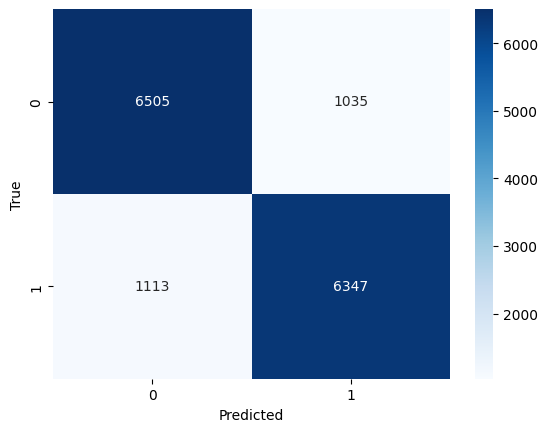

In [7]:
y_train_bool = (y_train == 'positivo').astype(int)
y_train_pred_bool = (y_train_pred == 'positivo').astype(int)
y_test_bool = (y_test == 'positivo').astype(int)
y_test_pred_bool = (y_test_pred == 'positivo').astype(int)

train_score = f1_score(y_train_bool.values, y_train_pred_bool)
test_score = f1_score(y_test_bool.values, y_test_pred_bool)

print("Matriz de confusión de los datos de prueba:")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [8]:
accuracy=accuracy_score(y_train_bool, y_train_pred_bool)
recall=recall_score(y_train_bool, y_train_pred_bool)
f1=f1_score(y_train_bool, y_train_pred_bool)
precision=precision_score(y_train_bool, y_train_pred_bool)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

accuracy=accuracy_score(y_test_bool,y_test_pred_bool)
recall=recall_score(y_test_bool,y_test_pred_bool)
f1=f1_score(y_test_bool,y_test_pred_bool)
precision=precision_score(y_test_bool,y_test_pred_bool)

print("\nCálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.914
Recall:  0.905
Precision:  0.921
F1 score:  0.913

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.857
Recall:  0.851
Precision:  0.86
F1 score:  0.855


## Predicción del conjunto test

In [9]:
test = pd.read_csv('test.csv')

predictions = pd.DataFrame()
predictions['ID'] = test['ID'].values
predictions['sentimiento'] = model.predict(test['review_es'])

predictions.to_csv('sample_submission.csv', index=False)